In [1]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn import metrics
from sklearn.random_projection import GaussianRandomProjection,SparseRandomProjection
from sklearn.decomposition import PCA, FastICA,TruncatedSVD
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:95% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')

Populating the interactive namespace from numpy and matplotlib


необходимые таблицы для прогноза - TempPurch3 и ##TempDate или (TempDate)

In [119]:
%%time
sql_query ="SELECT a.[PurchaseDate] \
      ,MONTH(a.[PurchaseDate]) Month \
      ,a.[PartnerID] \
      ,IIF(SEX='M',1,0) SEX \
      ,IIF(DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])> 100 , 0 , DATEDIFF(YEAR,[BirthDate],a.[PurchaseDate])) Age \
      ,[CityID] \
      ,DATEDIFF(DAY, [FirstVisit],a.[PurchaseDate])/30.0 LT  \
      ,DATEDIFF(DAY, t.LastDate,a.[PurchaseDate])/30.0 LastVisit_M  \
      ,[FirstVisit] \
      ,[QNTVisits] \
      ,[SumSMS] \
      ,[SumQuantity] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SUMM1] \
      ,[SUMM2] \
      ,[SUMM3] \
      ,[SUMM4] \
      ,[SUMM5] \
      ,[SUMM6] \
      ,[SUMM7] \
      ,[SUMM8] \
      ,[SUMM9] \
      ,[SUMM10] \
      ,[SUMM11] \
      ,[SUMM12] \
      ,[SUMP1k] \
      ,[SUMP3k] \
      ,[SUMP6k] \
      ,[SUMP12k] \
      ,[SUMP50k] \
      ,[SUMKolco] \
      ,[SUMSERGI] \
      ,[SUMPODVES] \
      ,[SUMCEP] \
      ,[SUMBRASLET] \
      ,[SUMKOLE] \
      ,[SUMCheap] \
      ,[SUMExpensive] \
      ,[SUMPremium] \
      ,[SUMMiddle] \
      ,[SUMZoloto] \
      ,[SUMSerebro] \
      ,[SUMColorBlack] \
      ,[SUMColorRed] \
      ,[SUMColorYellow] \
      ,[SUMColorWhite] \
      ,[SUMColor3] \
      ,[SUMColor2] \
      ,[SUMGroupBaza] \
      ,[SUMGroupClassic] \
      ,[SUMGroupModa] \
      ,[SUMGroupModul] \
      ,[SUMGroupSouvenir] \
      ,[SUMGroupTrend] \
      ,SUMDvaRavnoOdin \
      ,SUMDiscount \
      ,SUMPoints \
      ,SUMSertifikat \
      ,SUMSellOut \
      ,SUMShock \
      ,IIF(LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID,0,1) LastPurchase \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMDvaRavnoOdin],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMDvaRavnoOdin] IS NULL,0,1)), \
      1,0) NextDvaRavnoOdin \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMDiscount],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMDiscount] IS NULL,0,1)), \
      1,0) NextDiscount \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMPoints],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMPoints] IS NULL,0,1)), \
      1,0) NextPoints \
      ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMSertifikat],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMSertifikat] IS NULL,0,1)), \
	  1,0) NextSertifikat \
	  ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMSellOut],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMSellOut] IS NULL,0,1)), \
	  1,0) NextSellOut \
	  ,IIF((LEAD(a.PartnerID,1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) = a.PartnerID) and (LEAD([SUMShock],1,NULL) over (ORDER BY a.PartnerID,a.[PurchaseDate]) > IIF([SUMShock] IS NULL,0,1)), \
	  1,0) NextShock \
  FROM [Gold585].[dbo].[TempPurch3] a left join [Gold585].[dbo].TempDate2 t on a.PartnerID = t.PartnerID and a.PurchaseDate = t.PurchaseDate \
  order by PartnerID, PurchaseDate"

df = pd.read_sql(sql_query,conn)
df.head()

Wall time: 12min 3s


In [120]:
df.head()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMSertifikat,SUMSellOut,SUMShock,LastPurchase,NextDvaRavnoOdin,NextDiscount,NextPoints,NextSertifikat,NextSellOut,NextShock
0,2016-01-24,1,2,0,46,35,0.000000,NaN,2016-01-24,1,...,0,0,0,1,0,0,0,0,0,0
1,2016-01-24,1,3,1,49,72,0.000000,NaN,2016-01-24,1,...,0,0,0,1,0,0,0,0,0,0
2,2016-12-11,12,4,0,0,92,0.000000,NaN,2016-12-11,1,...,0,0,0,0,0,0,0,0,0,0
3,2016-12-18,12,4,0,0,92,0.233333,0.233333,2016-12-11,2,...,0,0,0,0,0,0,0,0,0,0
4,2018-02-14,2,4,0,0,92,14.333333,14.100000,2016-12-11,3,...,0,0,0,0,0,0,0,0,0,0


In [121]:
pred = df[df['LastPurchase']==1].fillna(0).reset_index(drop=True)
predId = pd.DataFrame(df[['PartnerID','CityID']][df['LastPurchase']==1],columns=['PartnerID','CityID']).reset_index(drop=True)
data = df[df['LastPurchase']!=1].fillna(0).reset_index(drop=True)
pred.head()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMSertifikat,SUMSellOut,SUMShock,LastPurchase,NextDvaRavnoOdin,NextDiscount,NextPoints,NextSertifikat,NextSellOut,NextShock
0,2016-01-24,1,2,0,46,35,0.000000,0.0,2016-01-24,1,...,0,0,0,1,0,0,0,0,0,0
1,2016-01-24,1,3,1,49,72,0.000000,0.0,2016-01-24,1,...,0,0,0,1,0,0,0,0,0,0
2,2018-08-25,8,4,0,0,92,20.733333,0.1,2016-12-11,8,...,0,0,0,1,0,0,0,0,0,0
3,2017-01-14,1,6,0,31,32,11.866666,0.0,2016-01-24,2,...,0,0,0,1,0,0,0,0,0,0
4,2016-01-24,1,9,0,0,122,0.000000,0.0,2016-01-24,1,...,0,0,0,1,0,0,0,0,0,0


In [122]:
predId.head()

,PartnerID,CityID
0,2,35
1,3,72
2,4,92
3,6,32
4,9,122


In [123]:
data.shape

(5626433, 68)

In [124]:
print(data['NextDvaRavnoOdin'].value_counts())
print(data['NextDiscount'].value_counts())
print(data['NextPoints'].value_counts())
print(data['NextSertifikat'].value_counts())
print(data['NextSellOut'].value_counts())
print(data['NextShock'].value_counts())

0    5513022
1     113411
Name: NextDvaRavnoOdin, dtype: int64
0    5421995
1     204438
Name: NextDiscount, dtype: int64
0    5422661
1     203772
Name: NextPoints, dtype: int64
0    5626104
1        329
Name: NextSertifikat, dtype: int64
0    5607932
1      18501
Name: NextSellOut, dtype: int64
0    5604085
1      22348
Name: NextShock, dtype: int64


In [125]:
data.columns

Index(['PurchaseDate', 'Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT',
       'LastVisit_M', 'FirstVisit', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5',
       'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11', 'SUMM12',
       'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco',
       'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro',
       'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow', 'SUMColorWhite',
       'SUMColor3', 'SUMColor2', 'SUMGroupBaza', 'SUMGroupClassic',
       'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir', 'SUMGroupTrend',
       'SUMDvaRavnoOdin', 'SUMDiscount', 'SUMPoints', 'SUMSertifikat',
       'SUMSellOut', 'SUMShock', 'LastPurchase', 'NextDvaRavnoOdin',
       'NextDiscount', 'NextPoints', 'NextSertifikat', 'NextSellOut',
       'NextShock'],
      dtype='object')

In [126]:
#dataColco1 = data[data['NextColco']==1] #.sample(300000)
#dataSERGI1 = data[data['NextSERGI']==1]
#dataPODVES1 = data[data['NextPODVES']==1]
#dataCEP1 = data[data['NextCEP']==1]
#dataBRASLET1 = data[data['NextBRASLET']==1]

#dataColco0 = data[data['NextColco']!=1]
#dataSERGI0 = data[data['NextSERGI']!=1].sample(800000)
#dataPODVES0 = data[data['NextPODVES']!=1].sample(550000)
#dataCEP0 = data[data['NextCEP']!=1].sample(500000)
#dataBRASLET0 = data[data['NextBRASLET']!=1].sample(300000)

X = data
#X = pd.concat([dataColco1,dataColco0],axis=0,ignore_index=True)
#XSERGI = pd.concat([dataSERGI1,dataSERGI0],axis=0,ignore_index=True)
#XPODVES = pd.concat([dataPODVES1,dataPODVES0],axis=0,ignore_index=True)
#XCEP = pd.concat([dataCEP1,dataCEP0],axis=0,ignore_index=True)
#XBRASLET = pd.concat([dataBRASLET1,dataBRASLET0],axis=0,ignore_index=True)

X.head()

,PurchaseDate,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,FirstVisit,QNTVisits,...,SUMSertifikat,SUMSellOut,SUMShock,LastPurchase,NextDvaRavnoOdin,NextDiscount,NextPoints,NextSertifikat,NextSellOut,NextShock
0,2016-12-11,12,4,0,0,92,0.000000,0.000000,2016-12-11,1,...,0,0,0,0,0,0,0,0,0,0
1,2016-12-18,12,4,0,0,92,0.233333,0.233333,2016-12-11,2,...,0,0,0,0,0,0,0,0,0,0
2,2018-02-14,2,4,0,0,92,14.333333,14.100000,2016-12-11,3,...,0,0,0,0,0,0,0,0,0,0
3,2018-06-07,6,4,0,0,92,18.100000,3.766666,2016-12-11,4,...,0,0,0,0,0,0,0,0,0,0
4,2018-07-17,7,4,0,0,92,19.433333,1.333333,2016-12-11,5,...,0,0,0,0,0,0,0,0,0,0


In [127]:
X.shape

(5626433, 68)

In [128]:
X.columns

Index(['PurchaseDate', 'Month', 'PartnerID', 'SEX', 'Age', 'CityID', 'LT',
       'LastVisit_M', 'FirstVisit', 'QNTVisits', 'SumSMS', 'SumQuantity',
       'SumSumma', 'AVGSumma', 'SUMM1', 'SUMM2', 'SUMM3', 'SUMM4', 'SUMM5',
       'SUMM6', 'SUMM7', 'SUMM8', 'SUMM9', 'SUMM10', 'SUMM11', 'SUMM12',
       'SUMP1k', 'SUMP3k', 'SUMP6k', 'SUMP12k', 'SUMP50k', 'SUMKolco',
       'SUMSERGI', 'SUMPODVES', 'SUMCEP', 'SUMBRASLET', 'SUMKOLE', 'SUMCheap',
       'SUMExpensive', 'SUMPremium', 'SUMMiddle', 'SUMZoloto', 'SUMSerebro',
       'SUMColorBlack', 'SUMColorRed', 'SUMColorYellow', 'SUMColorWhite',
       'SUMColor3', 'SUMColor2', 'SUMGroupBaza', 'SUMGroupClassic',
       'SUMGroupModa', 'SUMGroupModul', 'SUMGroupSouvenir', 'SUMGroupTrend',
       'SUMDvaRavnoOdin', 'SUMDiscount', 'SUMPoints', 'SUMSertifikat',
       'SUMSellOut', 'SUMShock', 'LastPurchase', 'NextDvaRavnoOdin',
       'NextDiscount', 'NextPoints', 'NextSertifikat', 'NextSellOut',
       'NextShock'],
      dtype='object')

In [105]:
%%time
#a = X['QNTVisits'].quantile(0.99)
#b = X['SumSumma'].quantile(0.99)
#X = X[X['QNTVisits']<a].reset_index(drop=True)
#X = X[X['SumSumma']<b].reset_index(drop=True)

Wall time: 0 ns


In [129]:
y_DvaRavnoOdin=X['NextDvaRavnoOdin'] # у всех будет что то без вложения - не интересно предсказывать
y_Discount=X['NextDiscount']
y_Points=X['NextPoints']
y_Sertifikat=X['NextSertifikat']
y_SellOut=X['NextSellOut']
y_Shock=X['NextShock']

#all_y_Colco = all_data['NextColco']
#all_y_Sergi = all_data['NextSERGI']
#all_y_PODVES = all_data['NextPODVES']
#all_y_CEP = all_data['NextCEP']
#all_y_BRASLET = all_data['NextBRASLET']

X.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextDvaRavnoOdin', 'NextDiscount', 'NextPoints', 'NextSertifikat',
       'NextSellOut', 'NextShock'],axis=1,inplace=True)
#XSERGI.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)
#XPODVES.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)
#XCEP.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)
#XBRASLET.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)

#all_data.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextGold', 'NextColco', 'NextSERGI', 'NextPODVES',
#       'NextCEP', 'NextBRASLET', 'NextCheap', 'NextExpensive', 'NextMiddle'],axis=1,inplace=True)

pred.drop(['PurchaseDate','FirstVisit','LastPurchase', 'NextDvaRavnoOdin', 'NextDiscount', 'NextPoints', 'NextSertifikat',
       'NextSellOut', 'NextShock'],axis=1,inplace=True)

In [130]:
print(X.shape)
print(len(y_DvaRavnoOdin))
#print(all_data.shape)
#print(len(all_y_Colco))
print(pred.shape)

(5626433, 59)
5626433
(4296307, 59)


In [131]:
X.head()

,Month,PartnerID,SEX,Age,CityID,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,...,SUMGroupModa,SUMGroupModul,SUMGroupSouvenir,SUMGroupTrend,SUMDvaRavnoOdin,SUMDiscount,SUMPoints,SUMSertifikat,SUMSellOut,SUMShock
0,12,4,0,0,92,0.000000,0.000000,1,0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,12,4,0,0,92,0.233333,0.233333,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,2,4,0,0,92,14.333333,14.100000,3,0,3.0,...,0,0,0,0,0,0,0,0,0,0
3,6,4,0,0,92,18.100000,3.766666,4,0,5.0,...,0,0,0,0,0,0,0,0,0,0
4,7,4,0,0,92,19.433333,1.333333,5,0,7.0,...,0,1,0,0,0,0,0,0,0,0


In [110]:
%%time
for_norm = pd.concat((X,pred),axis=0,ignore_index=True)

#for_norm_s = pd.concat((XSERGI,pred),axis=0,ignore_index=True)
#for_norm_p = pd.concat((XPODVES,pred),axis=0,ignore_index=True)
#for_norm_c = pd.concat((XCEP,pred),axis=0,ignore_index=True)
#for_norm_b = pd.concat((XBRASLET,pred),axis=0,ignore_index=True)

Wall time: 5.25 s


In [83]:
for_norm.columns

NameError: name 'for_norm' is not defined

In [16]:
%%time
for_norm = pd.get_dummies(for_norm, columns = ['CityID'],drop_first=True)

#for_norm_s = pd.get_dummies(for_norm_s, columns = ['SEX','CityID'],drop_first=True)
#for_norm_p = pd.get_dummies(for_norm_p, columns = ['SEX','CityID'],drop_first=True)
#for_norm_c = pd.get_dummies(for_norm_c, columns = ['SEX','CityID'],drop_first=True)
#for_norm_b = pd.get_dummies(for_norm_b, columns = ['SEX','CityID'],drop_first=True)

#all_data = pd.get_dummies(all_data, columns = ['SEX','CityID'],drop_first=True)

Wall time: 18.8 s


In [17]:
print(for_norm.shape)
#print(all_data.shape)

(4929573, 172)


In [18]:
for_norm.head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
0,1,1000,0,0,0.000000,0.000000,1,0,2,2237.0,...,0,0,0,0,0,0,0,0,0,0
1,12,1000,0,0,10.700000,10.700000,2,0,3,2580.0,...,0,0,0,0,0,0,0,0,0,0
2,1,1000,0,0,12.033333,1.333333,3,0,6,4719.0,...,0,0,0,0,0,0,0,0,0,0
3,2,1000,0,0,12.833333,0.800000,4,0,9,20298.0,...,0,0,0,0,0,0,0,0,0,0
4,7,1000,0,0,17.733333,4.900000,5,0,10,21369.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
%%time
scaler = StandardScaler()
scaler.fit(for_norm)
for_norm_2 = scaler.transform(for_norm)

#scaler = StandardScaler()
#scaler.fit(for_norm)
#for_norm_s = scaler.transform(for_norm)
#scaler = StandardScaler()
#scaler.fit(for_norm)
#for_norm_s = scaler.transform(for_norm)
#scaler = StandardScaler()
#scaler.fit(for_norm)
#for_norm_s = scaler.transform(for_norm)
#scaler = StandardScaler()
#scaler.fit(for_norm)
#for_norm_s = scaler.transform(for_norm)

#all_data_2 = scaler.transform(all_data)

Wall time: 2min 41s


In [20]:
for_norm_2= pd.DataFrame(for_norm_2,columns=for_norm.columns)
#all_data = pd.DataFrame(all_data_s,columns=all_data.columns)

In [21]:
X = for_norm_2[:X.shape[0]]
pred = for_norm_2[X.shape[0]:]
print(X.shape)
print(y_Colco.shape)
#print(all_data.shape)
#print(len(all_y_Colco))
print(pred.shape)

(2280623, 172)
(2280623,)
(2648950, 172)


In [22]:
pd.DataFrame(X).head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
0,-1.644437,-1.76534,-0.655296,-2.117742,-0.542748,-0.444020,-0.084015,-0.197609,-0.064963,-0.085990,...,-0.024216,-0.06806,-0.113011,-0.142109,-0.100082,-0.080599,-0.024052,-0.015539,-0.027056,-0.082808
1,1.410045,-1.76534,-0.655296,-2.117742,0.486549,1.292093,-0.048030,-0.197609,-0.045480,-0.084712,...,-0.024216,-0.06806,-0.113011,-0.142109,-0.100082,-0.080599,-0.024052,-0.015539,-0.027056,-0.082808
2,-1.644437,-1.76534,-0.655296,-2.117742,0.614810,-0.227682,-0.012045,-0.197609,0.012967,-0.076741,...,-0.024216,-0.06806,-0.113011,-0.142109,-0.100082,-0.080599,-0.024052,-0.015539,-0.027056,-0.082808
3,-1.366757,-1.76534,-0.655296,-2.117742,0.691767,-0.314217,0.023941,-0.197609,0.071415,-0.018684,...,-0.024216,-0.06806,-0.113011,-0.142109,-0.100082,-0.080599,-0.024052,-0.015539,-0.027056,-0.082808
4,0.021644,-1.76534,-0.655296,-2.117742,1.163127,0.351023,0.059926,-0.197609,0.090898,-0.014693,...,-0.024216,-0.06806,-0.113011,-0.142109,-0.100082,-0.080599,-0.024052,-0.015539,-0.027056,-0.082808


In [23]:
pred.head()

,Month,PartnerID,SEX,Age,LT,LastVisit_M,QNTVisits,SumSMS,SumQuantity,SumSumma,...,CityID_119,CityID_120,CityID_121,CityID_122,CityID_123,CityID_124,CityID_125,CityID_126,CityID_127,CityID_128
2280623,-1.644437,-1.765919,-0.655296,-0.903040,-0.542748,-0.444020,-0.084015,-0.197609,-0.084446,-0.092568,...,-0.024216,-0.06806,-0.113011,-0.142109,-0.100082,-0.080599,-0.024052,-0.015539,-0.027056,-0.082808
2280624,-1.644437,-1.765866,1.526028,-0.417159,-0.542748,-0.444020,-0.084015,-0.197609,-0.084446,-0.040664,...,-0.024216,-0.06806,-0.113011,-0.142109,-0.100082,-0.080599,-0.024052,-0.015539,-0.027056,-0.082808
2280625,0.577004,-1.765340,-0.655296,-2.117742,2.541936,0.891868,0.131897,-0.197609,0.149345,-0.001755,...,-0.024216,-0.06806,-0.113011,-0.142109,-0.100082,-0.080599,-0.024052,-0.015539,-0.027056,-0.082808
2280626,-1.089076,-1.181390,-0.655296,-0.599365,0.980355,2.124995,-0.048030,-0.197609,-0.064963,-0.060191,...,-0.024216,-0.06806,-0.113011,-0.142109,-0.100082,-0.080599,-0.024052,-0.015539,-0.027056,-0.082808
2280627,-1.644437,-1.181390,1.526028,-2.117742,-0.542748,-0.444020,-0.084015,-0.197609,-0.084446,-0.072683,...,-0.024216,-0.06806,-0.113011,-0.142109,-0.100082,-0.080599,-0.024052,-0.015539,-0.027056,-0.082808


In [132]:
#y_DvaRavnoOdin
#y_Discount, y_Points, y_Sertifikat, y_SellOut, y_Shock

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y_DvaRavnoOdin, test_size=0.25, random_state=42,stratify=y_DvaRavnoOdin,shuffle =True)

In [134]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC1 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC1, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC1.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC1.predict_proba(X_test)
labels =  ExTC1.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.99      1.00      1.00   1378256
          1       0.92      0.60      0.72     28353

avg / total       0.99      0.99      0.99   1406609

[[1376840    1416]
 [  11453   16900]]
0.7975147346602398
0.9036695491368735
Wall time: 5min 8s


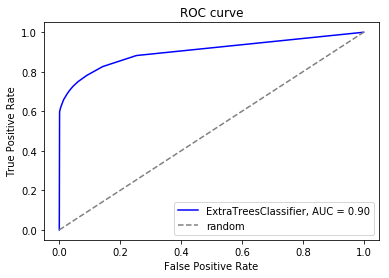

In [135]:
preds = predicted[:,1]
fpr, tpr, treshold = metrics.roc_curve(expected, preds)
roc_auc = metrics.auc(fpr, tpr)
pylab.title('ROC curve')
pylab.plot(fpr, tpr,'b', label = 'ExtraTreesClassifier, AUC = %0.2f' % roc_auc)
pylab.plot([0, 1],[0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.legend(loc = 'lower right')

In [136]:
predict = ExTC1.predict_proba(pred)[:,1]
predictedID = pd.concat([predId,pd.DataFrame(predict,columns=['DvaRavnoOdin'])],axis=1,ignore_index=False)

In [137]:
(predictedID['DvaRavnoOdin']>0.3).value_counts()

False    4240735
True       55572
Name: DvaRavnoOdin, dtype: int64

In [138]:
predictedID.head()

,PartnerID,CityID,DvaRavnoOdin
0,2,35,0.01
1,3,72,0.00
2,4,92,0.02
3,6,32,0.02
4,9,122,0.00


In [139]:
#y_Discount
#y_Points, y_Sertifikat, y_SellOut, y_Shock

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y_Discount, test_size=0.25, random_state=42,stratify=y_Discount,shuffle =True)

In [141]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC2 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC2, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC2.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC2.predict_proba(X_test)
labels =  ExTC2.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.98      1.00      0.99   1355499
          1       0.92      0.60      0.72     51110

avg / total       0.98      0.98      0.98   1406609

[[1352965    2534]
 [  20669   30441]]
0.7968641540642
0.9142874487842635
Wall time: 5min 20s


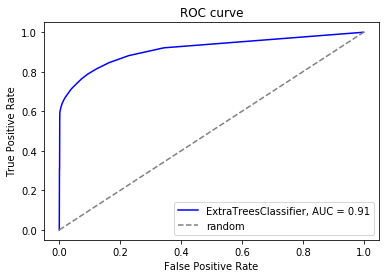

In [142]:
preds = predicted[:,1]
fpr, tpr, treshold = metrics.roc_curve(expected, preds)
roc_auc = metrics.auc(fpr, tpr)
pylab.title('ROC curve')
pylab.plot(fpr, tpr,'b', label = 'ExtraTreesClassifier, AUC = %0.2f' % roc_auc)
pylab.plot([0, 1],[0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.legend(loc = 'lower right')

In [143]:
predict = ExTC2.predict_proba(pred)[:,1]
predictedID = pd.concat([predictedID,pd.DataFrame(predict,columns=['Discount'])],axis=1,ignore_index=False)
predictedID.head()

,PartnerID,CityID,DvaRavnoOdin,Discount
0,2,35,0.01,0.01
1,3,72,0.00,0.00
2,4,92,0.02,0.01
3,6,32,0.02,0.02
4,9,122,0.00,0.00


In [144]:
(predictedID['Discount']>0.3).value_counts()

False    4179275
True      117032
Name: Discount, dtype: int64

In [145]:
#y_Points
#y_Sertifikat, y_SellOut, y_Shock

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y_Points, test_size=0.25, random_state=42,stratify=y_Points,shuffle =True)

In [147]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC3 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC3, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC3.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC3.predict_proba(X_test)
labels =  ExTC3.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       0.98      1.00      0.99   1355666
          1       0.92      0.59      0.72     50943

avg / total       0.98      0.98      0.98   1406609

[[1353078    2588]
 [  21035   29908]]
0.7925892522050046
0.9160734539434068
Wall time: 5min 19s


In [148]:
predict = ExTC3.predict_proba(pred)[:,1]
predictedID = pd.concat([predictedID,pd.DataFrame(predict,columns=['Points'])],axis=1,ignore_index=False)
predictedID.head()

,PartnerID,CityID,DvaRavnoOdin,Discount,Points
0,2,35,0.01,0.01,0.02
1,3,72,0.00,0.00,0.00
2,4,92,0.02,0.01,0.00
3,6,32,0.02,0.02,0.04
4,9,122,0.00,0.00,0.02


In [149]:
(predictedID['Discount']>0.3).value_counts()

False    4179275
True      117032
Name: Discount, dtype: int64

In [150]:
#y_Sertifikat
#y_SellOut, y_Shock

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y_Sertifikat, test_size=0.25, random_state=42,stratify=y_Sertifikat,shuffle =True)

In [152]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC4 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC4, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC4.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC4.predict_proba(X_test)
labels =  ExTC4.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1406527
          1       0.94      0.37      0.53        82

avg / total       1.00      1.00      1.00   1406609

[[1406525       2]
 [     52      30]]
0.6829261182972269
0.7552382527334626
Wall time: 2min 30s


In [153]:
predict = ExTC4.predict_proba(pred)[:,1]
predictedID = pd.concat([predictedID,pd.DataFrame(predict,columns=['Sertifikat'])],axis=1,ignore_index=False)
predictedID.head()

,PartnerID,CityID,DvaRavnoOdin,Discount,Points,Sertifikat
0,2,35,0.01,0.01,0.02,0.0
1,3,72,0.00,0.00,0.00,0.0
2,4,92,0.02,0.01,0.00,0.0
3,6,32,0.02,0.02,0.04,0.0
4,9,122,0.00,0.00,0.02,0.0


In [154]:
(predictedID['Sertifikat']>0.1).value_counts()

False    4295952
True         355
Name: Sertifikat, dtype: int64

In [155]:
#y_SellOut
#y_Shock

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y_SellOut, test_size=0.25, random_state=42,stratify=y_SellOut,shuffle =True)

In [157]:
%%time
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC5 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC5, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC5.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC5.predict_proba(X_test)
labels =  ExTC5.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1401984
          1       0.87      0.44      0.58      4625

avg / total       1.00      1.00      1.00   1406609

[[1401679     305]
 [   2603    2022]]
0.718485820172062
0.8641253812357961
Wall time: 4min 17s


In [158]:
predict = ExTC5.predict_proba(pred)[:,1]
predictedID = pd.concat([predictedID,pd.DataFrame(predict,columns=['SellOut'])],axis=1,ignore_index=False)
predictedID.head()

,PartnerID,CityID,DvaRavnoOdin,Discount,Points,Sertifikat,SellOut
0,2,35,0.01,0.01,0.02,0.0,0.0
1,3,72,0.00,0.00,0.00,0.0,0.0
2,4,92,0.02,0.01,0.00,0.0,0.0
3,6,32,0.02,0.02,0.04,0.0,0.0
4,9,122,0.00,0.00,0.02,0.0,0.0


In [159]:
(predictedID['SellOut']>0.3).value_counts()

False    4284881
True       11426
Name: SellOut, dtype: int64

In [160]:
#y_Shock

In [161]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y_Shock, test_size=0.25, random_state=42,stratify=y_Shock,shuffle =True)

from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit a CART model to the data
ExTC6 = ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=42, # n_estimators=700,
           verbose=0, warm_start=False)
param_grid = { 
    'n_estimators': [200, 700],
    'class_weight':['balanced'],
   # 'max_depth' : [2,200,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}
model = GridSearchCV(estimator=ExTC6, param_grid=param_grid, cv= 5)
#model.fit(X_train, y_train)
ExTC6.fit(X_train, y_train)
#print(model)
# make predictions
expected = y_test
#predicted = model.predict(X_test)
predicted = ExTC6.predict_proba(X_test)
labels =  ExTC6.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, labels))
print(metrics.confusion_matrix(expected, labels))
print(roc_auc_score(expected, labels))
print(roc_auc_score(expected, predicted[:,1]))
#ExtraTreesClassifier
predict = ExTC6.predict_proba(pred)[:,1]
predictedID = pd.concat([predictedID,pd.DataFrame(predict,columns=['Shock'])],axis=1,ignore_index=False)
predictedID.head()

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   1401022
          1       0.95      0.69      0.80      5587

avg / total       1.00      1.00      1.00   1406609

[[1400798     224]
 [   1717    3870]]
0.8462597755580435
0.9340640611547618
Wall time: 4min 53s


In [162]:
(predictedID['Shock']>0.3).value_counts()

False    4288663
True        7644
Name: Shock, dtype: int64

In [163]:
predictedID.head(40)

,PartnerID,CityID,DvaRavnoOdin,Discount,Points,Sertifikat,SellOut,Shock
0,2,35,0.01,0.01,0.020000,0.0,0.00,0.00
1,3,72,0.00,0.00,0.000000,0.0,0.00,0.00
2,4,92,0.02,0.01,0.000000,0.0,0.00,0.00
3,6,32,0.02,0.02,0.040000,0.0,0.00,0.00
4,9,122,0.00,0.00,0.020000,0.0,0.00,0.01
5,10,105,0.00,0.01,0.000000,0.0,0.00,0.00
6,12,29,0.00,0.01,0.000000,0.0,0.00,0.00
7,14,101,0.01,0.00,0.000000,0.0,0.00,0.00
8,15,92,0.04,0.02,0.020000,0.0,0.00,0.00
9,16,92,0.00,0.00,0.000000,0.0,0.00,0.00


In [164]:
predictedID.to_csv('Commun_pred.csv')

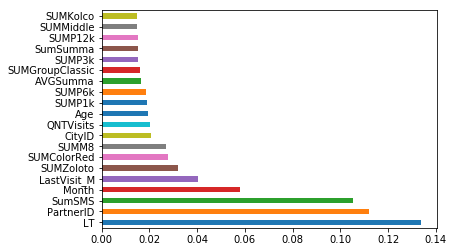

In [118]:
feat_importances = pd.Series(ExTC5.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [263]:
predict = ExTC.predict(pred)

In [282]:
predictedID_metall = pd.concat([predId,pd.DataFrame(predict,columns=['Zoloto'])],axis=1,ignore_index=False)

In [283]:
predictedID_metall.head()

,PartnerID,Zoloto
0,10,0
1,100,1
2,1000,1
3,1000037,1
4,1000038,1


In [284]:
predictedID_metall['Zoloto'].value_counts()

1    2058236
0     590714
Name: Zoloto, dtype: int64